In [1]:
import os
import numpy as np
import cv2

from keras.models import Sequential
import keras.layers
from sklearn.model_selection import train_test_split
from skimage.util import random_noise

In [2]:
# image functions
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

def toGray(im, im_L=10, im_W=10, contrast=1.0):
    # normalize
    gray = np.zeros([im_L, im_W])
    for j in range(im_L):
        for i in range(im_W):
            gray[j][i] = max(im[j][i]) * contrast
    gray = convert(gray, 0, 255, np.uint8)
    # print(type(gray[0][0]))
    return gray

In [3]:
# import data and label data
num_samples = 200
sample_set = np.empty([num_samples*9, 10, 10],dtype=np.uint8)
sample_labels = np.empty(num_samples*9)
baseDir = 'ShapeGroups GRAY'
idx = 0
shape_id = 0
for filename in os.listdir(baseDir):
    folder = baseDir + '/' + filename
    for imagepath in os.listdir(folder):
        imagepathFull = folder + '/' + imagepath
        sample_set[idx] = cv2.imread(imagepathFull, cv2.IMREAD_GRAYSCALE)
        sample_labels[idx] = shape_id
        # print("\n" + im
        # print(training_set[idx])
        idx += 1
    shape_id += 1
sample_set = sample_set[0:idx,]
sample_labels = sample_labels[0:idx,]

In [4]:
print(type(sample_set[0][0][0]))

<class 'numpy.uint8'>


In [5]:
# add padding - 11 rows and columns on each side for 32x32
sample_size = len(sample_set)
X_set = np.empty([sample_size, 32, 32], dtype=np.uint8)
for idx in range(sample_size):
    X_set[idx] = np.pad(sample_set[idx], ((11, 11), (11, 11)), 'constant', constant_values=(0, 0))

print(np.shape(X_set[0]))
print(type(X_set[0,0,0]))

(32, 32)
<class 'numpy.uint8'>


In [6]:
# Split Dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_set, sample_labels, test_size=0.33, random_state=42)

print(len(X_train))
print(len(X_test))
# print(Y_test)

957
472


In [7]:
# Set up CNN
model = Sequential()

# Convolution 1: Input = 32x32x1, Output = 28x28x6
# Subsampling 1: Input = 28x28x6, Output = 14x14x6
model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(keras.layers.AveragePooling2D())

# Convolution 2: Input = 14x14x6, Output = 10x10x16
# Subsampling 2: Input = 10x10x16, Output = 5x5x16
model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.AveragePooling2D())

# Fully Connected Layers
model.add(keras.layers.Flatten())

# Input = 5x5x16, Output = 120
model.add(keras.layers.Dense(units=120, activation='relu'))
# Input = 120, Output = 84
model.add(keras.layers.Dense(units=84, activation='relu'))

# Softmax output - modified for 6 shapes
model.add(keras.layers.Dense(units=6, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (Average  (None, 15, 15, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 6, 6, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [8]:
# Train the network
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the ANN model iteratively for n_epochs
n_epochs = 5
history = model.fit(x=X_train,y=Y_train, epochs=n_epochs, batch_size=128, validation_data=(X_test, Y_test))

Epoch 1/5
8/8 [==============================] - 1s 47ms/step - loss: 1.8319 - accuracy: 0.5214 - val_loss: 0.6556 - val_accuracy: 0.7945
Epoch 2/5
8/8 [==============================] - 0s 22ms/step - loss: 0.4407 - accuracy: 0.8861 - val_loss: 0.3008 - val_accuracy: 0.9386
Epoch 3/5
8/8 [==============================] - 0s 25ms/step - loss: 0.2360 - accuracy: 0.9206 - val_loss: 0.2094 - val_accuracy: 0.9343
Epoch 4/5
8/8 [==============================] - 0s 22ms/step - loss: 0.1437 - accuracy: 0.9645 - val_loss: 0.1528 - val_accuracy: 0.9894
Epoch 5/5
8/8 [==============================] - 0s 23ms/step - loss: 0.1016 - accuracy: 0.9885 - val_loss: 0.1135 - val_accuracy: 0.9915


In [9]:
def calc_Categorical_Accuracy(test, truth, num_categories):
    truth = truth.astype(int)
    certainty = model.predict(test, verbose=0)
    decision = np.argmax(certainty, axis=1)  # find index of max probability

    categorical_accuracy = np.zeros(shape=(num_categories,))
    for i in range(len(decision)):
      if decision[i] == truth[i]:
          categorical_accuracy[truth[i]] = categorical_accuracy[truth[i]]+1

    for i in range(num_categories):
        num_tests = truth.tolist().count(i)
        categorical_accuracy[i] = categorical_accuracy[i]/num_tests
    return categorical_accuracy

print("Testing:")
acc = calc_Categorical_Accuracy(X_test, Y_test, 6)
print(acc)

print("Training:")
acc = calc_Categorical_Accuracy(X_train, Y_train, 6)
print(acc)

Testing:
[1.         1.         1.         1.         0.94520548 1.        ]
Training:
[1.         1.         1.         1.         0.94117647 1.        ]


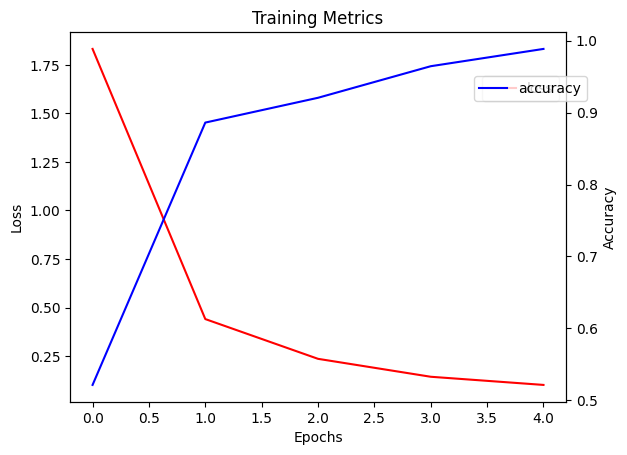

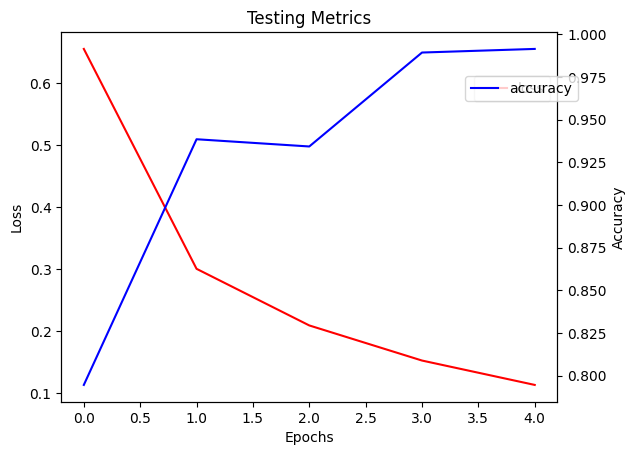

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(history.history['loss'], color='r')
ax2.plot(history.history['accuracy'], color='b')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax.title.set_text('Training Metrics')
ax.set_xlabel("Epochs")
ax.legend(['loss'], bbox_to_anchor =(1, .9))
ax2.legend(['accuracy'], bbox_to_anchor =(.8, .9))
plt.show()

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(history.history['val_loss'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')
ax.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
ax.title.set_text('Testing Metrics')
ax.set_xlabel("Epochs")
ax.legend(['loss'], bbox_to_anchor =(1, .9))
ax2.legend(['accuracy'], bbox_to_anchor =(.8, .9))
plt.show()


In [11]:
import tensorflow as tf

# get predictions and convert them into classifications
Y_pred = np.empty(shape= [len(Y_test)],dtype=int)
predictions = model.predict(X_test, verbose=0)
for idx in range(len(predictions)):
    Y_pred[idx] = predictions[idx].argmax()

# generate confusion matrix for test set
conf_matrix = tf.math.confusion_matrix(labels=np.transpose(Y_test),
                                      predictions=Y_pred)
print(conf_matrix)

tf.Tensor(
[[74  0  0  0  0  0]
 [ 0 86  0  0  0  0]
 [ 0  0 84  0  0  0]
 [ 0  0  0 79  0  0]
 [ 0  0  2  0 69  2]
 [ 0  0  0  0  0 76]], shape=(6, 6), dtype=int32)


In [23]:
model.save('shape_recognition.keras')

In [12]:
import random
def add_noise(img):

    # Getting the dimensions of the image
    row , col = img.shape

    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):

        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        # Color that pixel to white
        img[y_coord][x_coord] = 255

    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):

        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)

        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)

        # Color that pixel to black
        img[y_coord][x_coord] = 0

    return img

<class 'numpy.uint8'>
<class 'numpy.uint8'>


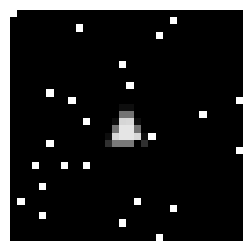

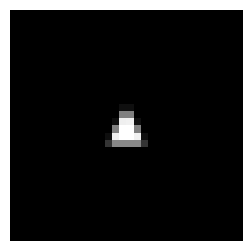

tf.Tensor(
[[45  0  2 21  2  4]
 [ 1 19  0 12  1 53]
 [25  0 15 16 18 10]
 [ 1  0  0 77  0  1]
 [21  3  6 12 20 11]
 [ 0  0  0  4  0 72]], shape=(6, 6), dtype=int32)


In [13]:
# Add noise to Inference
# print(sample_set[0])
# set_noise = np.zeros_like(sample_set)
# for im_idx in range(np.shape(X_test)[0]):
#     set_noise[im_idx] = random_noise(sample_set[im_idx], mode='salt')
# print(set_noise[0])
# # Pad samples to 32x32 input
# sample_size = len(sample_set)
# X_noise = np.empty([sample_size, 32, 32])
# for idx in range(sample_size):
#     X_noise[idx] = np.pad(sample_set[idx], ((11, 11), (11, 11)), 'constant', constant_values=(0, 0))
#
# # Split Dataset
# X_noise_train, X_noise_test, Y_noise_train, Y_noise_test = train_test_split(X_set, sample_labels, test_size=0.33, random_state=42)
sample_idx = 0
X_noise_test = np.zeros_like(X_test, dtype=np.uint8)
for im_idx in range(np.shape(X_test)[0]):
    im = random_noise(X_test[im_idx], mode='s&p')
    im_uint = convert(im, 0, 255, np.uint8)
    X_noise_test[im_idx] = im_uint
print(type(X_test[sample_idx,0,0]))
print(type(X_noise_test[sample_idx,0,0]))
# print(X_test[sample_idx,11:20, 11:20])
# print(X_noise_test[sample_idx,11:20, 11:20])
# plot
ax = plt.axes()
plt.imshow(X_noise_test[sample_idx], cmap='gray')
ax.axis('tight')
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()
ax = plt.axes()
plt.imshow(X_test[sample_idx], cmap='gray')
ax.axis('tight')
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(3, 3)
plt.show()


# get predictions and convert them into classifications
# Y_pred = np.empty(shape= [len(Y_noise_test)],dtype=int)
Y_pred = np.empty(shape= [len(Y_test)],dtype=int)
predictions = model.predict(X_noise_test, verbose=0)
for idx in range(len(predictions)):
    Y_pred[idx] = predictions[idx].argmax()

# generate confusion matrix for test set
conf_matrix = tf.math.confusion_matrix(labels=np.transpose(Y_test),
                                      predictions=Y_pred)
print(conf_matrix)

In [14]:
# LeNet Implementation for Sequence Recognition

In [70]:
# get dataset!
image_sets = ['train.large', 'train.med', 'train.small', 'train.tiny']
training_image_files = './exp_shapes/shapes_dataset/%s.input.npy'
training_images_list = []

for image_set in image_sets:
    training_images_list.append(np.load(training_image_files % image_set))

num_samples = 200
image_set = np.concatenate(training_images_list)[0:num_samples]

In [71]:
x_set = np.zeros([num_samples, 30, 30], dtype=np.uint8)
for im_idx in range(num_samples):
    x_set[im_idx] = toGray(image_set[im_idx], 30, 30)
x_set_flat = np.zeros([num_samples, 10, 90], dtype=np.uint8)

for im_idx in range(num_samples):
    sample = x_set[im_idx]
    x_set_flat[im_idx] = np.concatenate((sample[0:10, :], sample[10:20, ], sample[20:30, :]), axis=1)

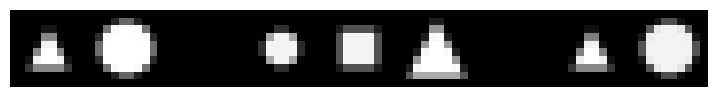

In [72]:
ax = plt.axes()
plt.imshow(x_set_flat[0], cmap='gray')
ax.axis('tight')
ax.axis('off')
fig = plt.gcf()
fig.set_size_inches(9, 1)
plt.show()

In [77]:
# takes recognition model and 10x10 shape array
def predictShape(shape, model):
    # im_uint = np.zeros_like(shape, dtype=np.uint8)
    # x_in = np.empty([1, 32, 32], dtype=np.uint8)
    # x_in = np.pad(shape, ((11, 11), (11, 11)), 'constant', constant_values=(0, 0))
    # im = random_noise(x_in, mode='s&p')
    # im_uint = convert(im, 0, 255, np.uint8)
    #
    # im_uint = tf.expand_dims(im_uint, 0)
    shape = tf.expand_dims(shape, 0)
    # print(np.shape(x_in))
    prediction = model.predict(shape, verbose=0)
    return prediction.argmax() # returns the shape with the highest confidence

# takes 10x90 array of shapes and a sequence to see if it appears in the array WITH NOISE!! <-- Read that (very important)
def predictSequenceNoise(shapes_in, model):
    pred_sequence = ''
    for idx in range(9):
        input = shapes_in[:,10*idx:10*(idx+1)]
        pred_sequence += str(predictShape(input, model))
    return pred_sequence

In [78]:
predictions = []
for idx in range(np.shape(x_set_flat)[0]):
    predictions.append(predictSequenceNoise(x_set_flat[idx], model))
    print(idx, predictions[-1])

0 335303505
1 503005000
2 424455333
3 010310500
4 550035031
5 325345305
6 533335050
7 333051053
8 303533552
9 205533553
10 330350353
11 005032555
12 553455403
13 500555533
14 033235533
15 501553233
16 013255534
17 553333450
18 104345553
19 015353503
20 233305535
21 532243533
22 510350033
23 525523333
24 330353133
25 355513305
26 333353053
27 341514353
28 353101045
29 453205540
30 020555520
31 554455355
32 354353502
33 032350530
34 305355505
35 431233334
36 055532550
37 501352135
38 000320300
39 030335503
40 535550403
41 333503530
42 535305513
43 055513335
44 333004530
45 513505500
46 305353023
47 555354545
48 113333005
49 333054053
50 354510303
51 403554030
52 553013334
53 025030533
54 305535355
55 335303353
56 300333555
57 435353003
58 431253335
59 503345405
60 345330555
61 535523340
62 330143333
63 303445130
64 530000050
65 553103354
66 553055331
67 335030101
68 505033335
69 053035535
70 335335543
71 003350010
72 045310405
73 153400153
74 153350550
75 554003403
76 355301353
77 043300

In [88]:
# print(predictSequence(x_set_flat[0], '243', model))
sequence = '025'

indices = [i for i, x in enumerate(predictions) if sequence in x]
print(indices, len(indices))

[53, 112, 180, 190, 198] 5
